Major class: palmprints with large number of hosts association, high node degree
Minor class: palmprints with few number of host association, low node degree

Major class: palmprints with high read depth, total edge weight
Minor class: palmprints with low read depth, total edge weight

TODO:
- to investigate:
   - read depth distribution vs. num of hosts distribution
   - investigate if edge distribution has skewed drastically in test set after using weights in rwr
   - investigate impact of not using weights in total class ratio calculations
- [ ] train model on full dataset, compare evals of validation set vs. reweighted dataset


In [4]:
# Notebook config
import sys
if '../' not in sys.path:
    sys.path.append("../")
%load_ext dotenv
%dotenv

# Actual imports
import os
from collections import defaultdict

from queries import (feature_queries, gds_queries, utils)
from datasources.neo4j import gds

import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [5]:
df_has_host = feature_queries.get_features_from_file(
    file_name='has_host_edges.csv',
    dir_name='/mnt/graphdata/features/',
)
df_has_host = df_has_host.loc[:, ~df_has_host.columns.str.contains('^Unnamed')]
print(df_has_host.head())

Using local cached file /mnt/graphdata/features/has_host_edges.csv
   sourceNodeId  targetNodeId relationshipType    weight  weightUnscaled
0       7759509       8755886         HAS_HOST  0.000000               1
1       8092634       8755889         HAS_HOST  0.000000               1
2       7720184       8755889         HAS_HOST  0.000000               1
3       8631494       8755900         HAS_HOST  0.000149               7
4       8434803       8755900         HAS_HOST  0.000323              14


1
3275


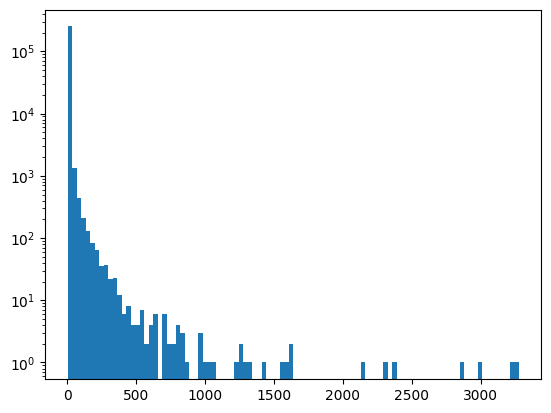

In [6]:
palmprint_to_hosts = defaultdict(list)
palmprint_to_read_depth = defaultdict(int)
palmprint_to_host_counts = defaultdict(int)
hosts_per_palmprint = []

for index, row in df_has_host.iterrows():
    palmprint_to_hosts[row['sourceNodeId']].append(row['targetNodeId'])
    palmprint_to_read_depth[row['sourceNodeId']] += row['weightUnscaled']

for palmprint, hosts in palmprint_to_hosts.items():
    palmprint_to_host_counts[palmprint] = len(set(hosts))

hosts_per_palmprint = list(palmprint_to_host_counts.values())

print(min(hosts_per_palmprint))
print(max(hosts_per_palmprint))

plt.figure()
plt.hist(hosts_per_palmprint, bins=100)
plt.yscale('log')
plt.show()

1
97325


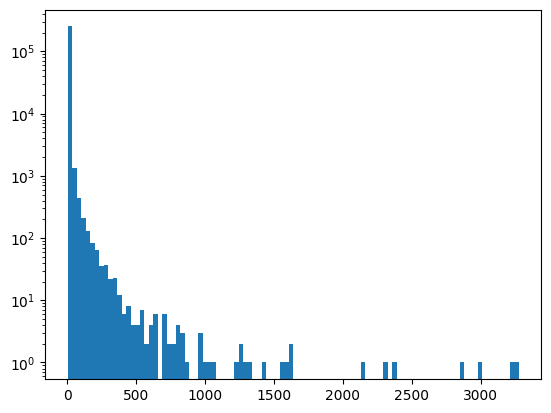

In [7]:
reads_per_palmprint = list(palmprint_to_read_depth.values())
print(min(reads_per_palmprint))
print(max(reads_per_palmprint))

plt.figure()
plt.hist(hosts_per_palmprint, bins=100)
plt.yscale('log')
plt.show()

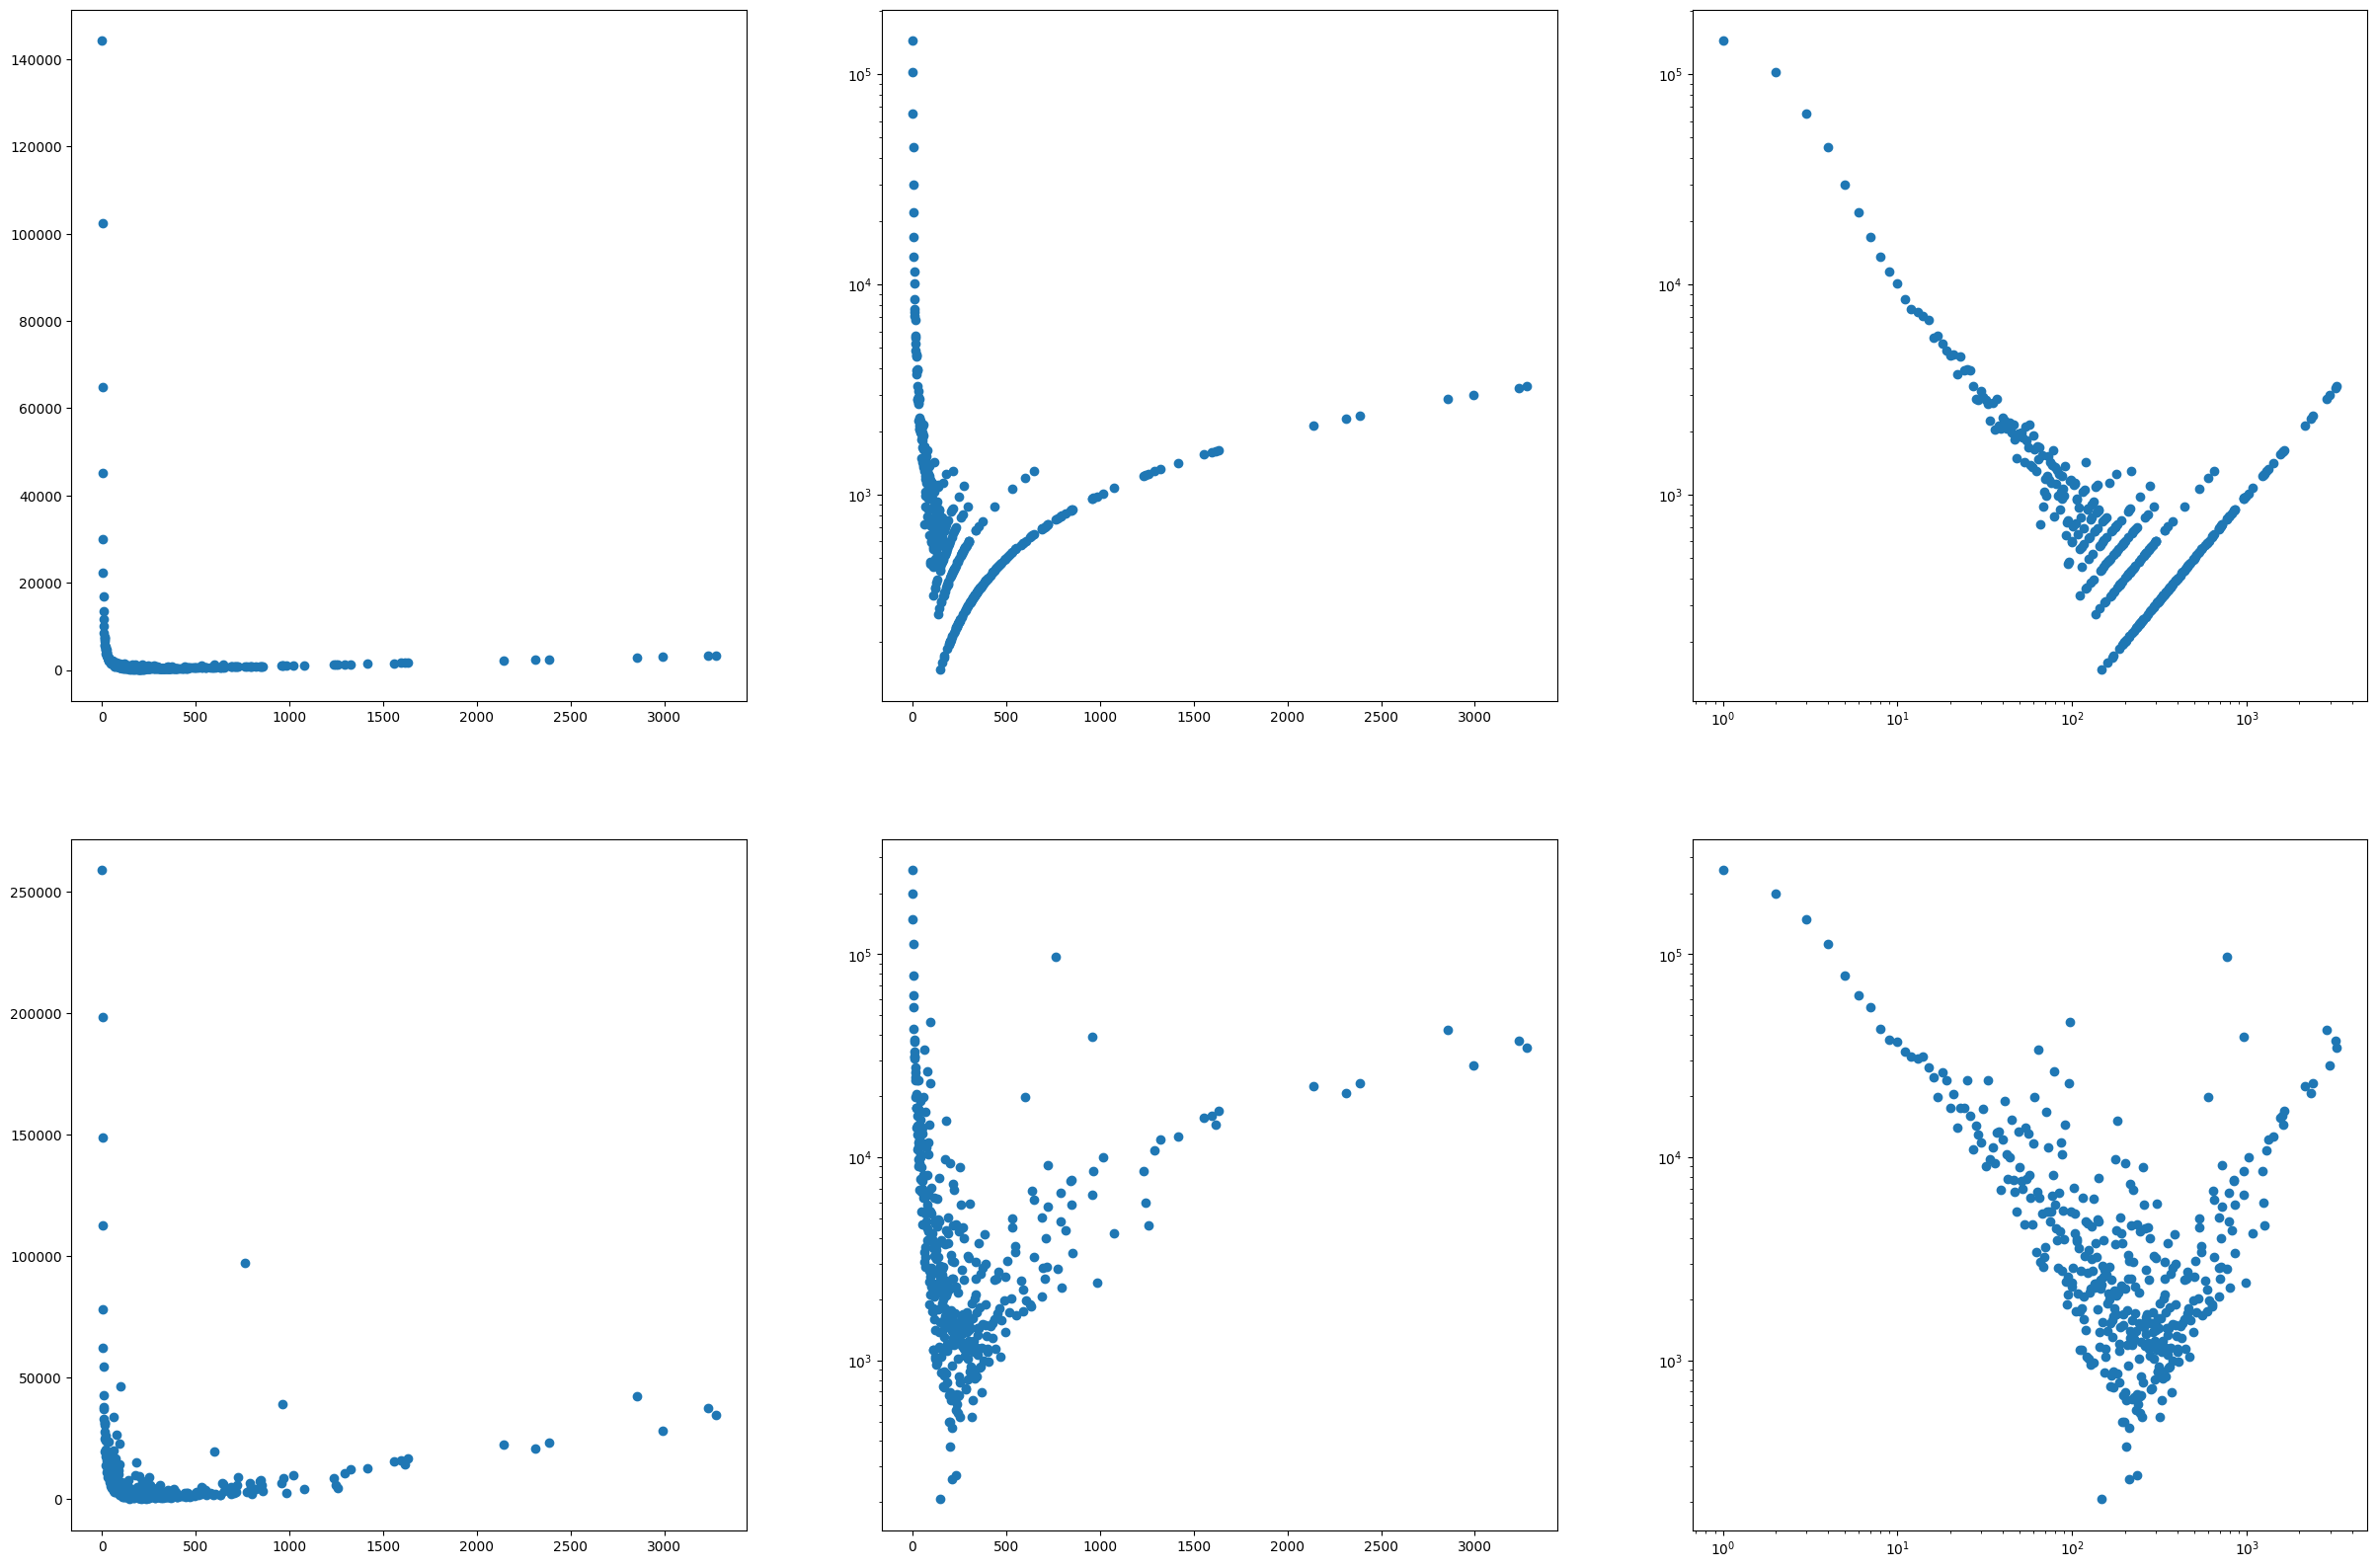

In [8]:
class_to_total_hosts = defaultdict(int)
for palmprint, hosts_count in palmprint_to_host_counts.items():
    class_to_total_hosts[hosts_count] += hosts_count

class_to_total_reads = defaultdict(int)
for palmprint, reads_count in palmprint_to_read_depth.items():
    class_to_total_reads[palmprint_to_host_counts[palmprint]] += reads_count


fig, axs = plt.subplots(2, 3)
fig.set_figwidth(30)
fig.set_figheight(20)
axs[0, 0].scatter(class_to_total_hosts.keys(), class_to_total_hosts.values())
axs[0, 1].scatter(class_to_total_hosts.keys(), class_to_total_hosts.values())
axs[0, 1].set_yscale('log')
axs[0, 2].scatter(class_to_total_hosts.keys(), class_to_total_hosts.values())
axs[0, 2].set_yscale('log')
axs[0, 2].set_xscale('log')


axs[1, 0].scatter(class_to_total_reads.keys(), class_to_total_reads.values())
axs[1, 1].scatter(class_to_total_reads.keys(), class_to_total_reads.values())
axs[1, 1].set_yscale('log')
axs[1, 2].scatter(class_to_total_reads.keys(), class_to_total_reads.values())
axs[1, 2].set_yscale('log')
axs[1, 2].set_xscale('log')

Major class:
	Num classes: 384
	AUC: 17595180.0
	Number of nodes: 12632
	Num has_host edges: 426344
Minor class:
	Num classes: 7
	AUC: 173941.5
	Num of nodes: 240400
	Num has_host edges: 425665


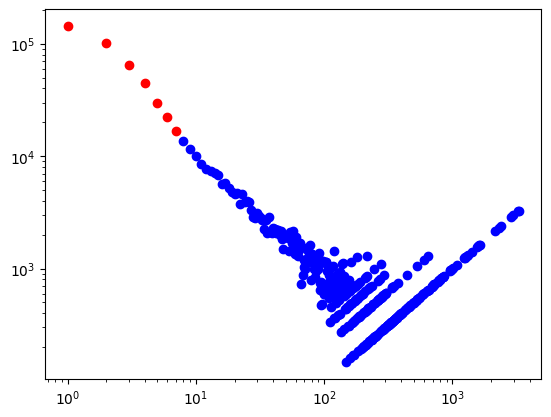

In [9]:

threshold = 7
palmprint_mapping = palmprint_to_host_counts
major_class_to_totals = defaultdict(int)
minor_class_to_totals = defaultdict(int)

major_class_palmprint_node_ids = []
minor_class_palmprint_node_ids = []

for palmprint, value in palmprint_mapping.items():
    
    count = len(value) if isinstance(value, list) else value

    if count <= threshold:
        minor_class_to_totals[count] += count
        minor_class_palmprint_node_ids.append(palmprint)
    else:
        major_class_to_totals[count] += count
        major_class_palmprint_node_ids.append(palmprint)

maj_auc = np.trapz(
    y=list(major_class_to_totals.values()),
    x=list(major_class_to_totals.keys())
)
min_auc = np.trapz(
    y=list(minor_class_to_totals.values()),
    x=list(minor_class_to_totals.keys())
)



maj_class_total = sum(major_class_to_totals.values())
min_class_total = sum(minor_class_to_totals.values())
num_maj_classes = len(major_class_to_totals)
num_min_classes = len(minor_class_to_totals)



print(f"Major class:")
print(f"\tNum classes: {num_maj_classes}")
print(f"\tAUC: {maj_auc}")
print(f"\tNumber of nodes: {len(major_class_palmprint_node_ids)}" )
print(f"\tNum has_host edges: {maj_class_total}")
print(f"Minor class:")
print(f"\tNum classes: {num_min_classes}")
print(f"\tAUC: {min_auc}")
print(f"\tNum of nodes: {len(minor_class_palmprint_node_ids)}" )
print(f"\tNum has_host edges: {min_class_total}")


plt.figure()
plt.scatter(major_class_to_totals.keys(), major_class_to_totals.values(), color='blue')
plt.scatter(minor_class_to_totals.keys(), minor_class_to_totals.values(), color='red')
plt.yscale('log')
plt.xscale('log')
plt.show()

In [10]:
reweight_min = num_maj_classes / (num_min_classes + num_maj_classes)
reweight_maj = 1 - reweight_min
print(f"Reweight major classes by {reweight_maj}")
print(f"Reweight minor classes by {reweight_min}")

# find intersection of 0.1 dataset with major/minor class nodeIds

dataset_dir = '/mnt/graphdata/datasets/palmprint-host-dataset_0.1/'

has_hosts_df = feature_queries.get_features_from_file(
    file_name='has_host_edges.csv',
    dir_name=dataset_dir
)

minor_nodes = pd.DataFrame(minor_class_palmprint_node_ids, columns=['sourceNodeId'])
minor_nodes = utils.df_to_ddf(minor_nodes)

minor_nodes_in_dataset = minor_nodes.merge(
    has_hosts_df,
    on='sourceNodeId',
    how='left',
).dropna().compute()

print(len(minor_nodes))
print(len(minor_nodes_in_dataset))

major_nodes = pd.DataFrame(major_class_palmprint_node_ids, columns=['sourceNodeId'])
major_nodes = utils.df_to_ddf(major_nodes)

major_nodes_in_dataset = major_nodes.merge(
    has_hosts_df,
    on='sourceNodeId',
    how='left',
).dropna().compute()

print(len(major_nodes))
print(len(major_nodes_in_dataset))

Reweight major classes by 0.01790281329923271
Reweight minor classes by 0.9820971867007673
Using local cached file /mnt/graphdata/datasets/palmprint-host-dataset_0.1/has_host_edges.csv
240400
43507
12632
92468


In [20]:
G_dataset = gds_queries.create_projection_from_dataset(sampling_ratio=0.1)

Using local file for dataframe:  /mnt/graphdata/datasets/palmprint-host-dataset_0.1/palmprint_nodes.csv
Using local file for dataframe:  /mnt/graphdata/datasets/palmprint-host-dataset_0.1/taxon_nodes.csv


Random walk with restarts sampling:   7%|▋         | 7.44/100 [10:22<2:09:03, 83.66s/%]


Using local file for dataframe:  /mnt/graphdata/datasets/palmprint-host-dataset_0.1/has_sotu_edges.csv
Using local file for dataframe:  /mnt/graphdata/datasets/palmprint-host-dataset_0.1/has_parent_edges.csv
Using local file for dataframe:  /mnt/graphdata/datasets/palmprint-host-dataset_0.1/has_host_edges_resampled.csv


In [21]:

# find intersection of 0.1 dataset with major/minor class nodeIds
# Load full graph projection
# load 0.1 dataset projection
# random walk with start nodes as major class nodes, and sample rate by reweight_maj, edges are all 
# random walk with start nodes as min class nodes, and sample rate by reweight_in, edges are all
# combine the two random walks and store as reweight_has_host_edges.csv
# compare number of total has_host edges 

graph_name = 'palmprint-host-dataset_0.1'
graph_name_minor = 'palmprint-host-dataset_0.1_minor'
graph_name_major = 'palmprint-host-dataset_0.1_major'
random_seed = 42

resampled_edges_minor, _ = gds.alpha.graph.sample.rwr(
    graph_name=graph_name_minor,
    from_G=G_dataset,
    concurrency=1,
    randomSeed=random_seed,
    samplingRatio=reweight_min,
    nodeLabelStratification=True,
    relationshipWeightProperty='weight',
    relationshipTypes=['HAS_HOST'],
    startNodes=minor_nodes_in_dataset['sourceNodeId'].tolist(),
)
dataset_rels_minor = gds.beta.graph.relationships.stream(
    resampled_edges_minor,
    relationship_types=['HAS_HOST'],
)
resampled_edges_minor.drop()


resampled_edges_major, _ = gds.alpha.graph.sample.rwr(
    graph_name=graph_name_major,
    from_G=G_dataset,
    concurrency=1,
    randomSeed=random_seed,
    samplingRatio=reweight_maj,
    nodeLabelStratification=True,
    relationshipWeightProperty='weight',
    relationshipTypes=['HAS_HOST'],
    startNodes=major_nodes_in_dataset['sourceNodeId'].tolist(),
)
dataset_rels_major = gds.beta.graph.relationships.stream(
    resampled_edges_major,
    relationship_types=['HAS_HOST'],
)
resampled_edges_major.drop()

print(len(dataset_rels_minor))
print(len(dataset_rels_major))

Random walk with restarts sampling:  46%|████▌     | 45.6/100 [04:54<03:08,  3.46s/%]    

KeyboardInterrupt: 

In [13]:
resampled_df = pd.concat([dataset_rels_minor, dataset_rels_major]).drop_duplicates().reset_index(drop=True)
df_dataset_rels = utils.df_to_ddf(resampled_df)

has_hosts_remapped = df_dataset_rels[['sourceNodeId', 'targetNodeId']].merge(
    has_hosts_df,
    on=['sourceNodeId', 'targetNodeId'],
    how='left',
).dropna().compute()

has_hosts_remapped.to_csv(dataset_dir + '/' +
                'has_host_edges_resampled.csv', index=False)

G_dataset.drop()

In [24]:
df_has_host_resampled = feature_queries.get_features_from_file(
    file_name='has_host_edges_resampled.csv',
    dir_name=dataset_dir,
)
df_has_host_resampled = df_has_host.loc[:, ~df_has_host.columns.str.contains('^Unnamed')]
print(df_has_host_resampled.head())

Using local cached file /mnt/graphdata/datasets/palmprint-host-dataset_0.1/has_host_edges_resampled.csv
   sourceNodeId  targetNodeId relationshipType    weight  weightUnscaled
0       7707961       8763618         HAS_HOST  0.000124             6.0
1       7701217       8763618         HAS_HOST  0.000000             1.0
2       7701377       8764020         HAS_HOST  0.000000             1.0
3       8133368       8763618         HAS_HOST  0.000025             2.0
4       8591313       8758855         HAS_HOST  0.000000             1.0


1
461


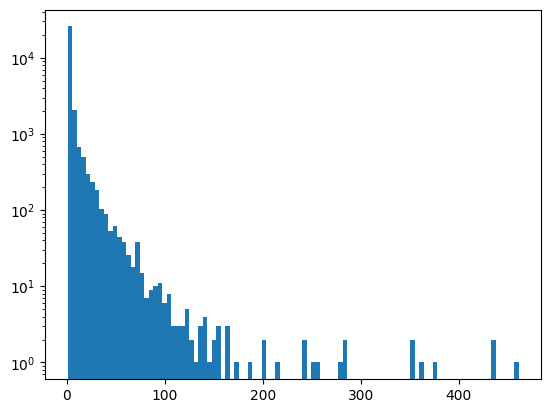

In [25]:
palmprint_to_hosts = defaultdict(list)
palmprint_to_read_depth = defaultdict(int)
palmprint_to_host_counts = defaultdict(int)
hosts_per_palmprint = []

for index, row in df_has_host_resampled.iterrows():
    palmprint_to_hosts[row['sourceNodeId']].append(row['targetNodeId'])
    palmprint_to_read_depth[row['sourceNodeId']] += row['weightUnscaled']

for palmprint, hosts in palmprint_to_hosts.items():
    palmprint_to_host_counts[palmprint] = len(set(hosts))

hosts_per_palmprint = list(palmprint_to_host_counts.values())

print(min(hosts_per_palmprint))
print(max(hosts_per_palmprint))

plt.figure()
plt.hist(hosts_per_palmprint, bins=100)
plt.yscale('log')
plt.show()

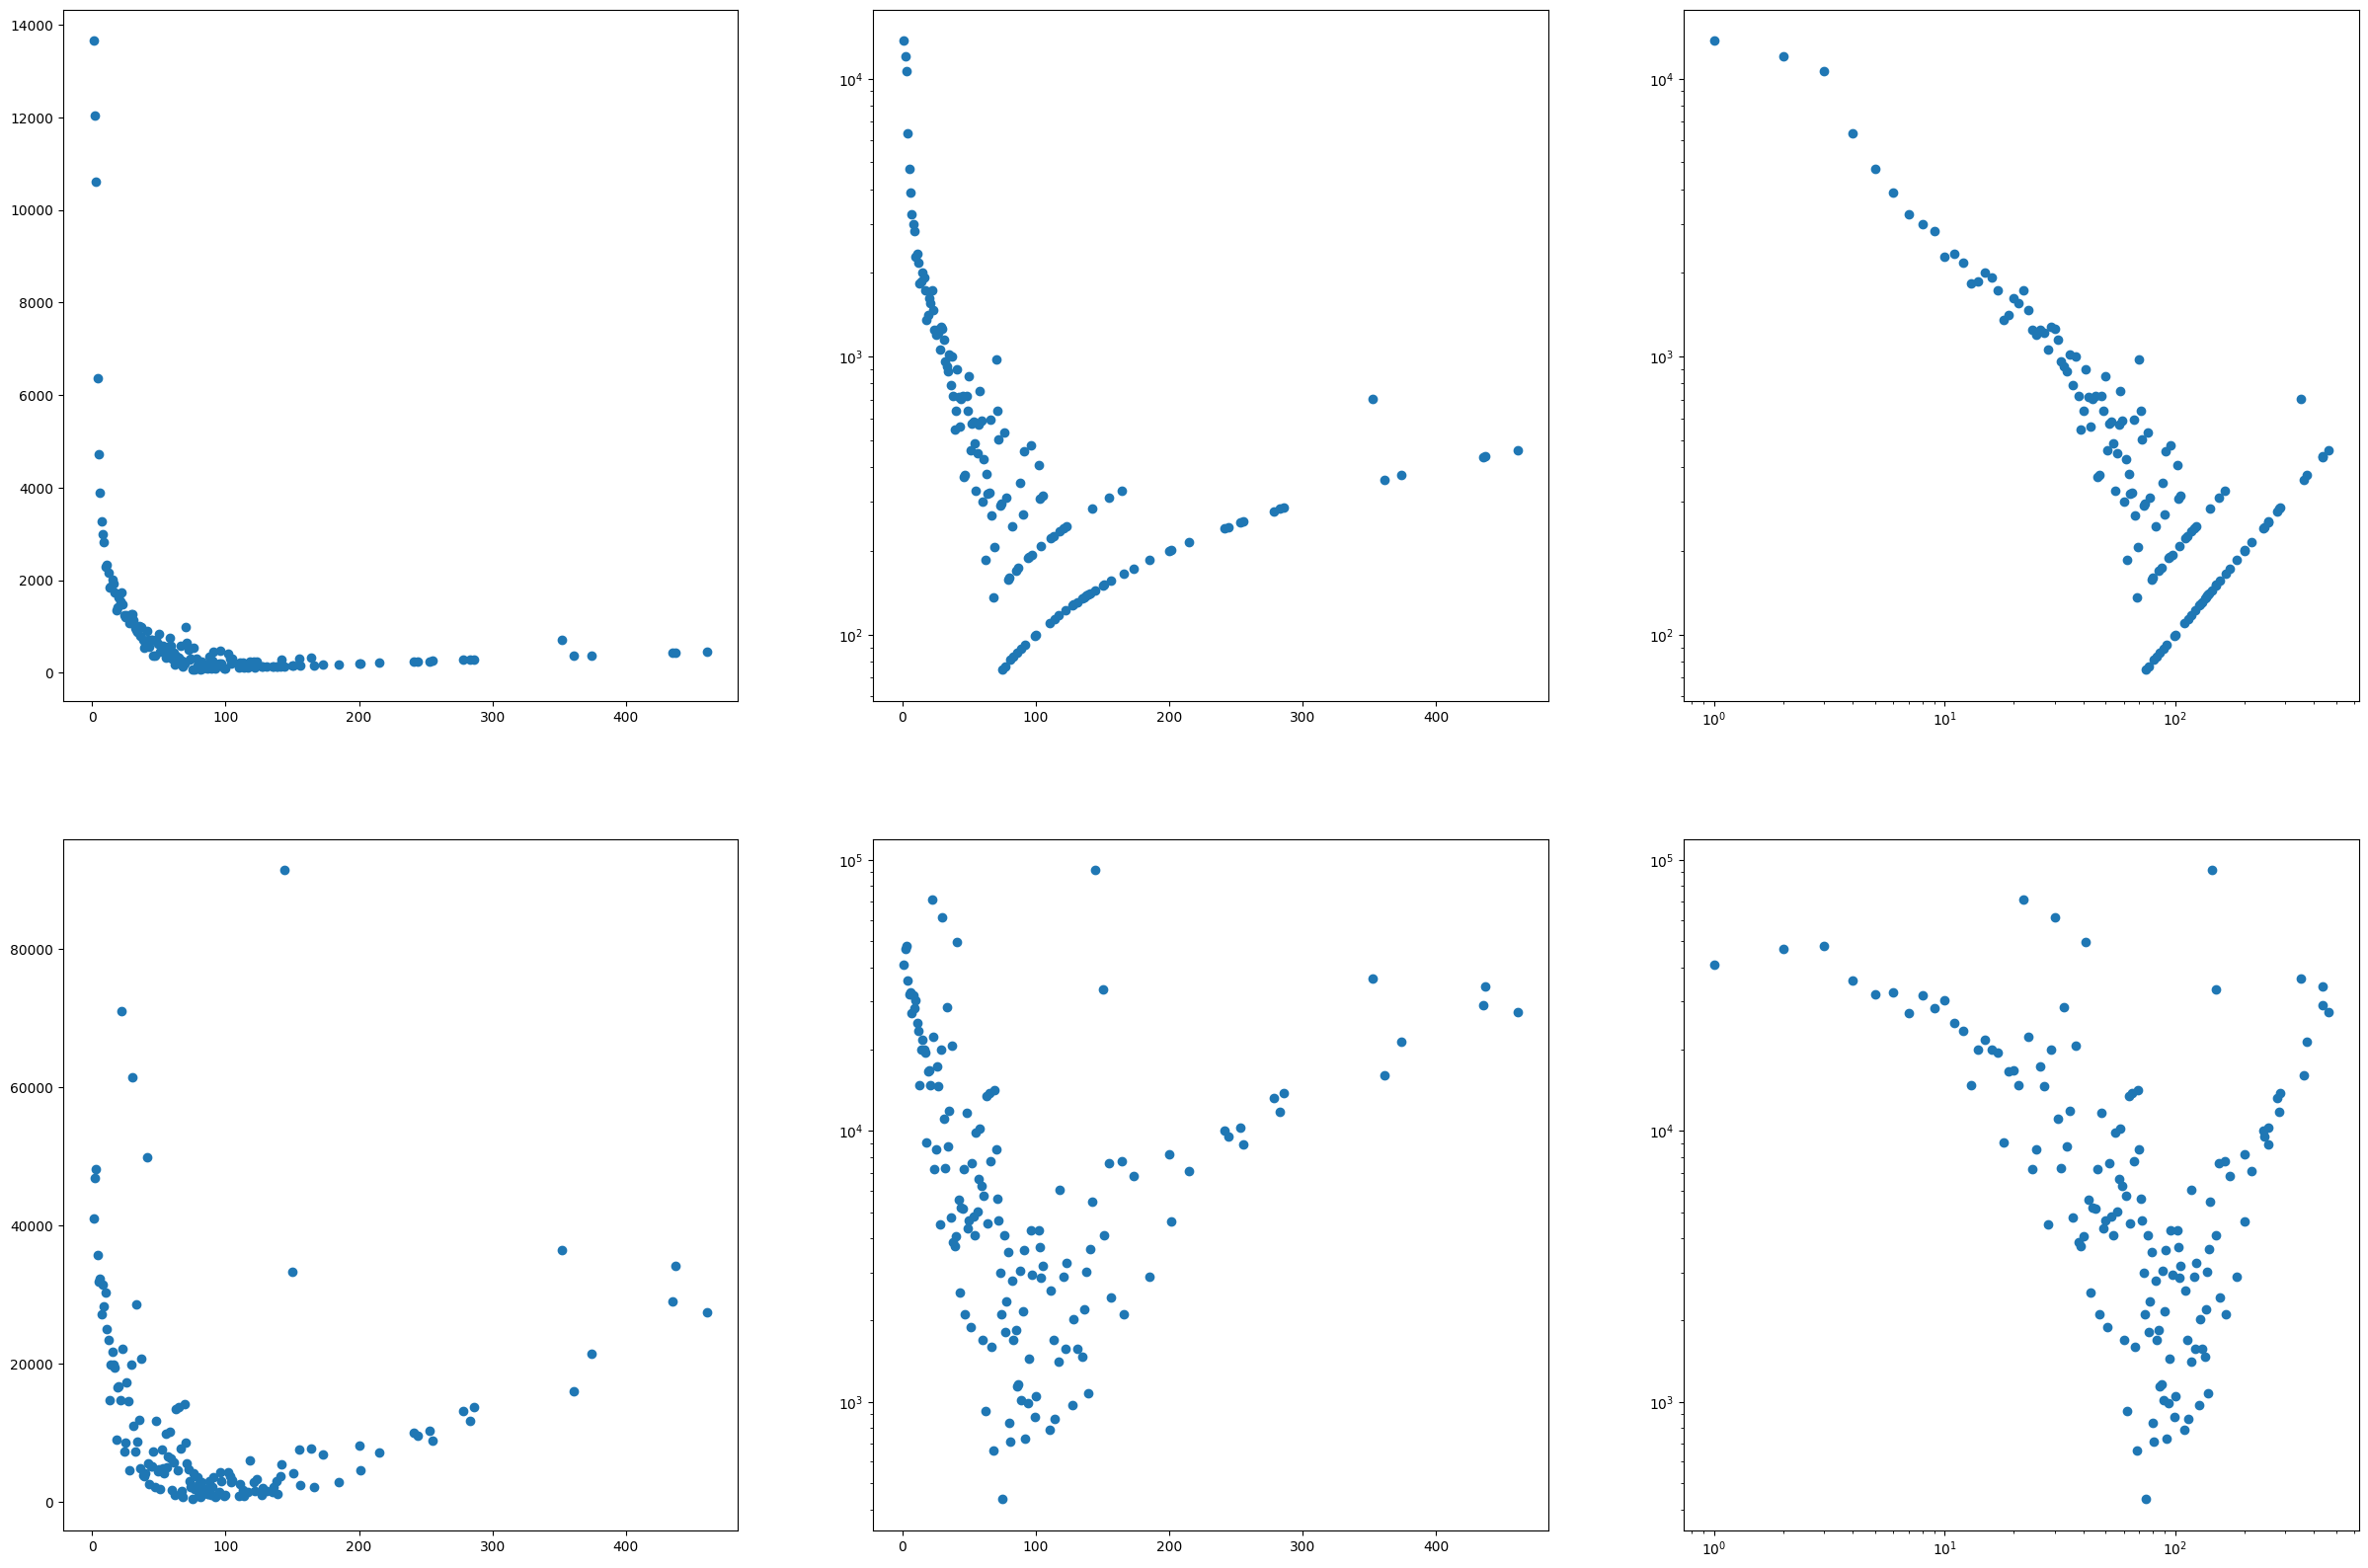

In [26]:
class_to_total_hosts = defaultdict(int)
for palmprint, hosts_count in palmprint_to_host_counts.items():
    class_to_total_hosts[hosts_count] += hosts_count

class_to_total_reads = defaultdict(int)
for palmprint, reads_count in palmprint_to_read_depth.items():
    class_to_total_reads[palmprint_to_host_counts[palmprint]] += reads_count


fig, axs = plt.subplots(2, 3)
fig.set_figwidth(30)
fig.set_figheight(20)
axs[0, 0].scatter(class_to_total_hosts.keys(), class_to_total_hosts.values())
axs[0, 1].scatter(class_to_total_hosts.keys(), class_to_total_hosts.values())
axs[0, 1].set_yscale('log')
axs[0, 2].scatter(class_to_total_hosts.keys(), class_to_total_hosts.values())
axs[0, 2].set_yscale('log')
axs[0, 2].set_xscale('log')


axs[1, 0].scatter(class_to_total_reads.keys(), class_to_total_reads.values())
axs[1, 1].scatter(class_to_total_reads.keys(), class_to_total_reads.values())
axs[1, 1].set_yscale('log')
axs[1, 2].scatter(class_to_total_reads.keys(), class_to_total_reads.values())
axs[1, 2].set_yscale('log')
axs[1, 2].set_xscale('log')